# Games EDA (Exploratory Data Analysis)

### Directory + install dotenv:

In [1]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)
print("Notebook is using:", sys.executable)
!{sys.executable} -m pip install python-dotenv

Project root: C:\Users\Gebruiker\Documents\SteamRecProject
Notebook is using: c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\python.exe



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports + load

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src.data.config import PROCESSED_DIR

%matplotlib inline

games_path = PROCESSED_DIR / "games.csv"
games_path

games = pd.read_csv(games_path)
games.head()

games.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15990 entries, 0 to 15989
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appid                15990 non-null  int64  
 1   name                 15989 non-null  object 
 2   type                 15990 non-null  object 
 3   required_age         15990 non-null  int64  
 4   is_free              15990 non-null  bool   
 5   release_date         15920 non-null  object 
 6   coming_soon          15990 non-null  bool   
 7   price_initial        14012 non-null  float64
 8   price_final          14012 non-null  float64
 9   discount_percent     14012 non-null  float64
 10  supported_languages  15978 non-null  object 
 11  genres               15951 non-null  object 
 12  categories           15986 non-null  object 
 13  windows              15990 non-null  bool   
 14  mac                  15990 non-null  bool   
 15  linux                15990 non-null 

### Filter "real" games and parse dates

In [3]:
# Focus on games only (ignore DLC, software, etc. for now)
games = games[games["type"] == "game"].copy()
games = games.dropna(subset=["name"])

# Parse release_date into datetime and year
games["release_date_parsed"] = pd.to_datetime(
    games["release_date"], errors="coerce"
)
games["release_year"] = games["release_date_parsed"].dt.year

games[["appid", "name", "release_date", "release_year"]].head()

,appid,name,release_date,release_year
0,10,Counter-Strike,"Nov 1, 2000",2000.0
1,20,Team Fortress Classic,"Apr 1, 1999",1999.0
2,30,Day of Defeat,"May 1, 2003",2003.0
3,40,Deathmatch Classic,"Jun 1, 2001",2001.0
4,50,Half-Life: Opposing Force,"Nov 1, 1999",1999.0


### How many games per year?

In [4]:
year_counts = games["release_year"].value_counts().sort_index()

year_counts.tail(20)  # last 20 years (just to see numbers)


release_year
2008.0     145
2009.0     292
2010.0     229
2011.0     242
2012.0     303
2013.0     438
2014.0    1400
2015.0    2261
2016.0    3730
2017.0    4069
2018.0    1044
2019.0     469
2020.0     281
2021.0     153
2022.0     116
2023.0      92
2024.0      73
2025.0      79
2026.0       2
2027.0       1
Name: count, dtype: int64

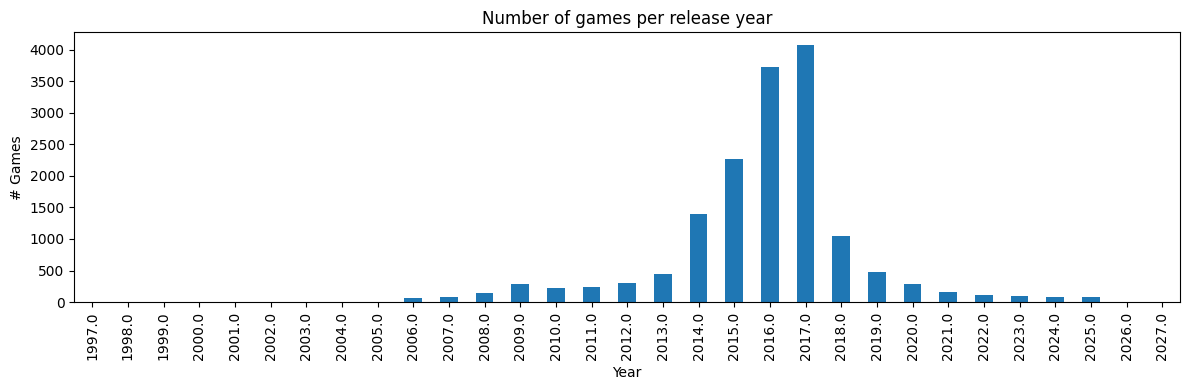

In [5]:
ax = year_counts.plot(
    kind="bar",
    figsize=(12, 4),
    title="Number of games per release year"
)
ax.set_xlabel("Year")
ax.set_ylabel("# Games")
plt.tight_layout()
plt.show()


### Price distribution

In [6]:
priced = games[(games["is_free"] == False) & games["price_final"].notna()].copy()
priced["price_eur"] = priced["price_final"] / 100.0

priced["price_eur"].describe()


count    14010.000000
mean         9.208743
std          8.807377
min          0.490000
25%          3.990000
50%          6.990000
75%         10.990000
max        199.990000
Name: price_eur, dtype: float64

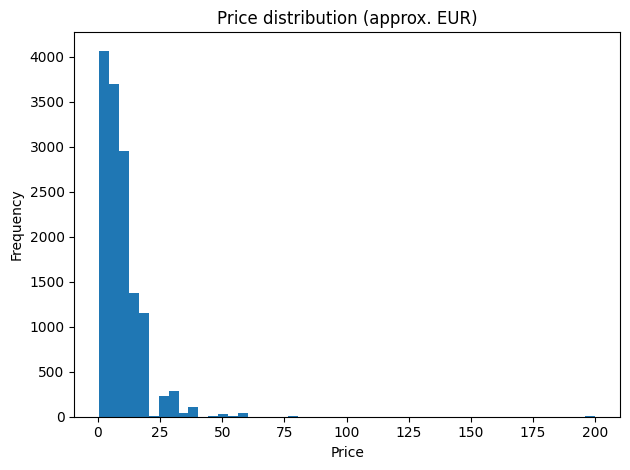

In [7]:
ax = priced["price_eur"].plot(
    kind="hist",
    bins=50,
    title="Price distribution (approx. EUR)"
)
ax.set_xlabel("Price")
plt.tight_layout()
plt.show()


### Genre exploration

In [8]:
def split_semicolon(s):
    if pd.isna(s) or not s:
        return []
    return [t.strip() for t in str(s).split(";") if t.strip()]

all_genres = []
for g in games["genres"]:
    all_genres.extend(split_semicolon(g))

genres_series = pd.Series(all_genres)
top_genres = genres_series.value_counts().head(20)
top_genres


Indie                    11075
Action                    7426
Adventure                 6165
Casual                    5257
Strategy                  3370
Simulation                3023
RPG                       2730
Early Access              1082
Free To Play               962
Sports                     724
Racing                     589
Massively Multiplayer      402
Violent                    214
Gore                       129
Nudity                      44
Sexual Content              35
Education                    3
Movie                        1
Audio Production             1
Software Training            1
Name: count, dtype: int64

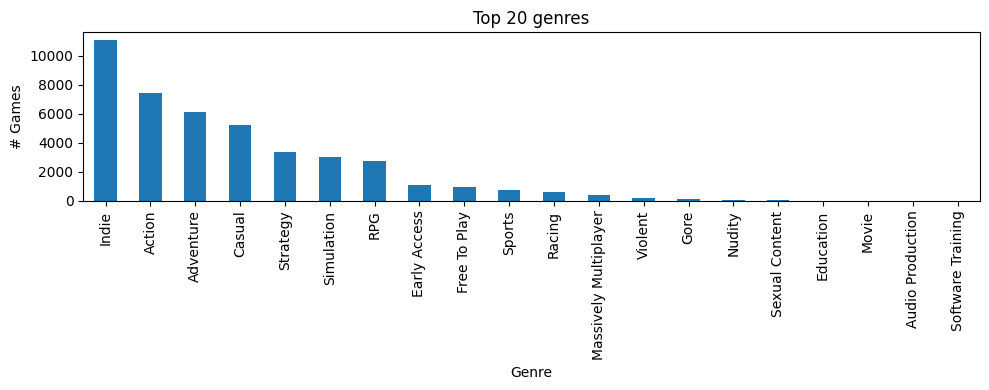

In [9]:
ax = top_genres.plot(
    kind="bar",
    figsize=(10, 4),
    title="Top 20 genres"
)
ax.set_xlabel("Genre")
ax.set_ylabel("# Games")
plt.tight_layout()
plt.show()


### Missing values overview

In [10]:
games.isna().sum().sort_values(ascending=False)


metacritic_score       13365
achievements_total      6248
price_final             1977
price_initial           1977
discount_percent        1977
release_year             405
release_date_parsed      405
release_date              70
genres                    38
supported_languages       11
categories                 3
appid                      0
required_age               0
type                       0
name                       0
coming_soon                0
is_free                    0
linux                      0
windows                    0
mac                        0
dtype: int64

- A lot of games dont have achievements.
- Metacritic score too sparse to rely on too much.

In [11]:
from src.recommender.content_based import ContentBasedRecommender

recommender = ContentBasedRecommender(n_neighbors=200)

games_clean_path = PROCESSED_DIR / "games_clean.csv"
games_clean = pd.read_csv(games_clean_path)

games_clean.sample(20)[["appid", "name", "genres"]]


,appid,name,genres
4962,357940,Telepath Tactics,Indie;RPG;Strategy
3650,317920,Hills Of Glory 3D,Casual;Indie;Strategy
5893,385250,Paint it Back,Casual
3983,330500,planktOs,Casual
6275,396590,CMYW,Action;Indie
12272,586140,BlazBlue Centralfiction,Action
5612,375900,Trackmania® Turbo,Massively Multiplayer;Racing
4342,341040,Wars Across The World,Indie;Strategy
3808,324080,Rising World,Action;Adventure;Early Access;Indie;RPG
150,6030,STAR WARS™ Jedi Knight II - Jedi Outcast™,Action


In [12]:
appid_test = 248820
recs = recommender.recommend_similar_by_appid(appid_test, top_n=50)
recs


,appid,name,distance,similarity,review_score_adj,review_volume_log,overall_score
0,113200,The Binding of Isaac,0.286764,0.713236,0.947494,4.787963,3.516719
1,252610,Death Road to Canada,0.255809,0.744191,0.925651,3.997648,3.484314
2,250900,The Binding of Isaac: Rebirth,0.341704,0.658296,0.972544,5.568080,3.479248
3,105600,Terraria,0.370452,0.629548,0.974321,6.163565,3.471837
4,239350,Spelunky,0.290956,0.709044,0.919742,4.215928,3.400819
5,242680,Nuclear Throne,0.319842,0.680158,0.959064,4.271075,3.362952
6,247080,Crypt of the NecroDancer,0.365435,0.634565,0.953510,4.415558,3.238956
7,249050,Dungeon of the ENDLESS™,0.359271,0.640729,0.854092,4.142296,3.116802
8,200210,Realm of the Mad God Exalt,0.375782,0.624218,0.828114,4.673878,3.108436
9,35720,Trine 2: Complete Story,0.418027,0.581973,0.951587,4.339690,3.069339
